In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('✔')

✔


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6SU39R/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6SU39R/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


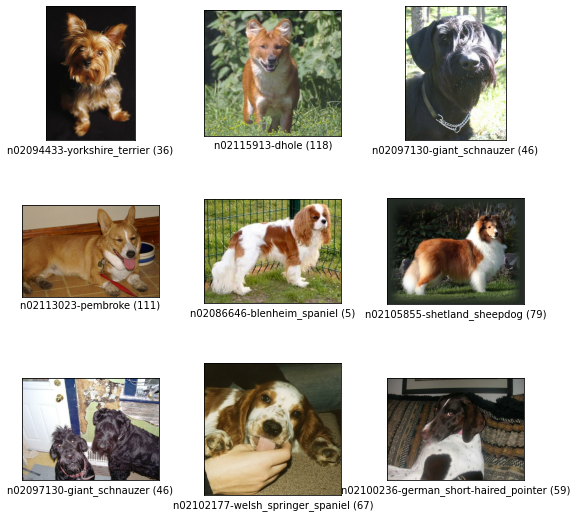

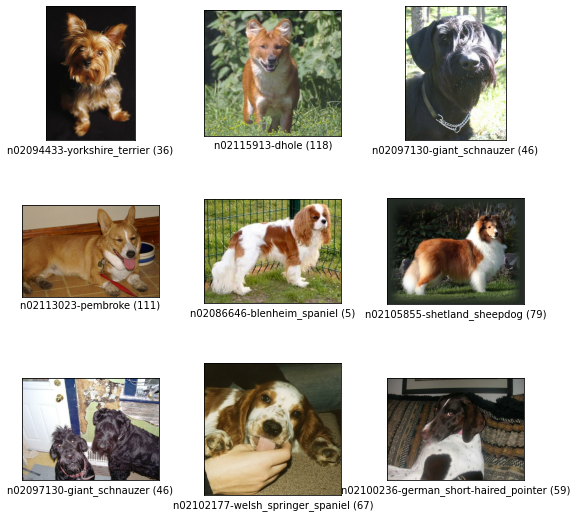

In [5]:
tfds.show_examples(ds_train, ds_info)

In [6]:
len(ds_train)
len(ds_test)

8580

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 2s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('✔')

✔


In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('✔')

✔


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 107s 122ms/step - loss: 2.1762 - accuracy: 0.4597 - val_loss: 3.2367 - val_accuracy: 0.2215
Epoch 2/10
750/750 [==============================] - 90s 120ms/step - loss: 0.7517 - accuracy: 0.7927 - val_loss: 1.0331 - val_accuracy: 0.6993
Epoch 3/10
750/750 [==============================] - 90s 119ms/step - loss: 0.2102 - accuracy: 0.9580 - val_loss: 0.9306 - val_accuracy: 0.7287
Epoch 4/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0550 - accuracy: 0.9951 - val_loss: 0.8916 - val_accuracy: 0.7457
Epoch 5/10
750/750 [==============================] - 90s 119ms/step - loss: 0.0223 - accuracy: 0.9997 - val_loss: 0.9088 - val_accuracy: 0.7463
Epoch 6/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0322 - accuracy: 0.9976 - val_loss: 0.9401 - val_accuracy: 0.7435
Epoch 7/10
750/750 [==============================] - 90s 121ms/step - loss: 0.0144 - accuracy: 0.9996 - val_loss: 0.9402 - val_a

In [13]:
import os

cam_model_path = '/content/drive/MyDrive/aiffel/weights/cam_model2.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


### batch, repeat, shuffle에 관해서
https://brainbow.tistory.com/31

사견으로 label이 정렬된 상태도 아니고 굳이 랜덤성이 필요하지 않고 epoch 수도 적기 때문에 batch로 먼저 묶어서 trainset을 만든 것으로 보인다.

In [14]:
ds_train_norm = apply_normalize_on_dataset

In [35]:
import random 

In [65]:
def get_one(ds):
    ds = ds.shuffle(1000)
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    # i = random.randint(0, 500)
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


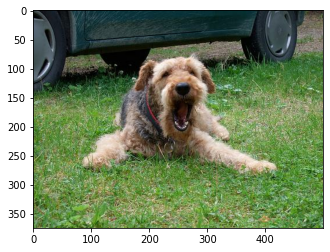

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

# 1. CAM 구현하기

- 논문에서는 ResNet으로 구현하는 부분은 나오지 않는다. 하지만 작동 원리를 알기 때문에 마지막 conv layer와 gap layer 가중치가 곱해지게 끔 모델을 설계한다.
- CNN모델은 4차원으로 Tensor 값들을 연산해나간다. 그래서 모델에서 동작하기 위해서는 conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) 코드가 필요하고, 후에 squeeze로 차원 축소하여 진행한다.
- 

In [17]:
import os
cam_model_path = '/content/drive/MyDrive/aiffel/weights/cam_model2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, img_label = normalize_and_resize_img(item)
    # normalize_and_resize_img 함수에서 return input['image'], input['label']이 
    # conv layer GAP이전의 output과 weight activation이 곱해지도록 구성

    #model = tf.keras.models.Model(inputs=inputs, outputs=[output_1, output_2])
    #layer별 output 값을 볼 수 있는 방법 : model.layers[index].output
    cam_model = tf.keras.models.Model(model.input, outputs = [model.layers[-3].output, model.layers[-1].output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) # 첫번째 인덱스 자리에 차원확장.
    # print(conv_outputs.shape) : 1, 7, 7, 2048 
    # print(predictions.shape) : class 별 가중치(확률)을 나타냄.

    conv_outputs = tf.squeeze(conv_outputs)
    # print(conv_outputs.shape) : 7,7,2048로 바꿔줌.(1값을 같은 차원 소거)
    gap_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation 가져오기

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    # print(cam_image) : 7,7 비어 있는 행렬을 만들어준다.

    for i, w in enumerate(gap_weights[:, img_label]):
        # W * f 를 통해 class별 activation map을 구해준다.

        cam_image += w * conv_outputs[:, :, i]
    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # numpy로 변환 후에 cv2.resize가 가능하다.

    return cam_image

### - model layer의 output 부분에 필요한 index 구분
(-3) conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                         
(-2) avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                        
                                                       
(-1) dense (Dense)                  (None, 120)          245880      ['avg_pool[0][0]']     

### - for i, w in enumerate(gap_weights[:, img_label]):
각 label에 대한 gap_weights 값들을 w에 저장하고 동시에 그에 해당하는 conv layer output값과 짝지어 곱연산을 해주기 위해서 enumerate로 i값을 받아 conv_outputs[:,:,i]을 통해 weights 값과 짝이 맞는 conv layer값을 불러왔다.

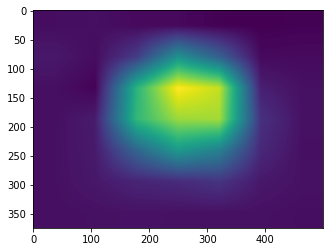

In [28]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [29]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

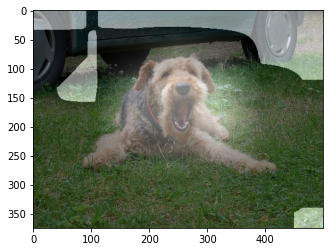

In [39]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 2. Grad-CAM 구현하기

108


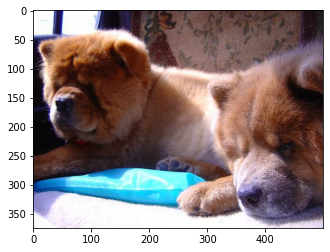

In [46]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [47]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

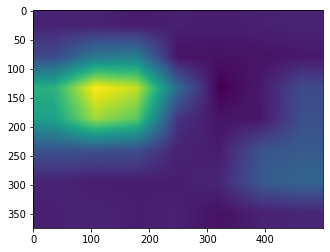

In [48]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

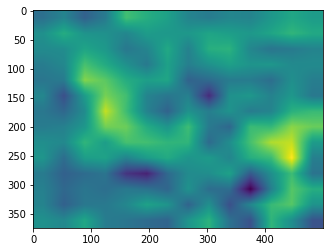

In [49]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

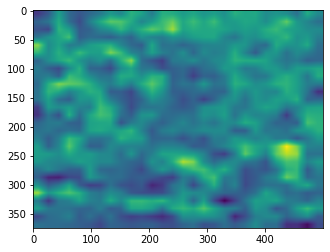

In [50]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

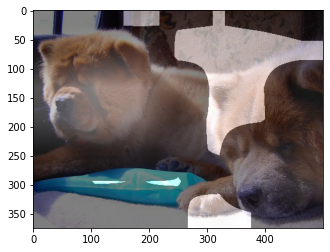

In [51]:
# cam on image
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 3. 바운딩 박스 구하기

In [52]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [53]:
rect = get_bbox(cam_image)
rect

array([[410, 337],
       [ 94, 296],
       [130,  16],
       [446,  57]])

In [76]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

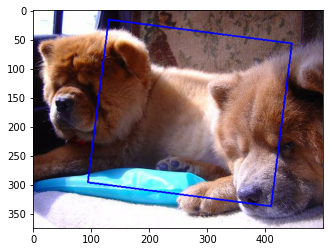

In [54]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# 4. IoU 구하기

In [55]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [56]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.042666666666666665, 0.188, 0.8986666666666666, 0.892]

In [57]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [58]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [59]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4321144435099388

# 5. 성능 비교

### CAM 결과

108


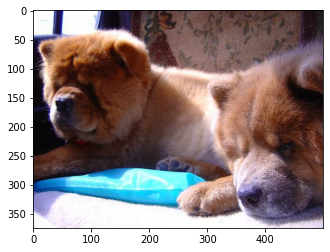

In [66]:
item2 = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

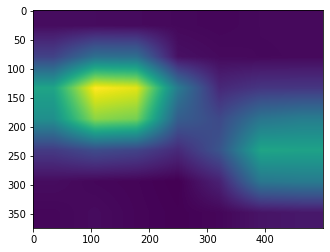

In [67]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [68]:
rect = get_bbox(cam_image)
rect

array([[496, 363],
       [-39, 273],
       [  5,   2],
       [541,  93]])

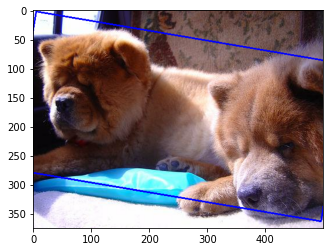

In [69]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [70]:
# IoU
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.38119685056045816

### Grad-CAM 결과

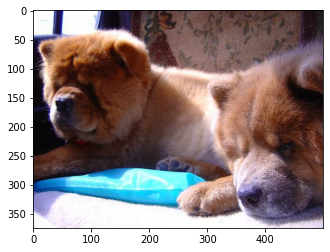

In [71]:
plt.imshow(item['image'])
plt.show()

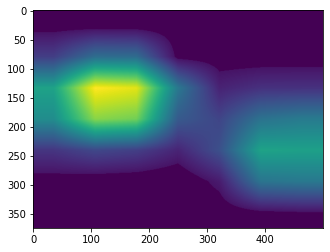

In [72]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(cam_image)
plt.show()

In [73]:
rect = get_bbox(grad_cam_image,)
rect

array([[331, 341],
       [331, 102],
       [499, 102],
       [499, 341]])

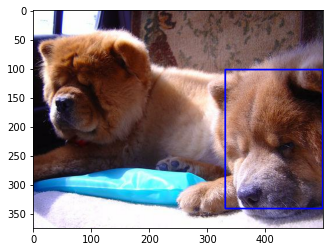

In [74]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [75]:
# IoU
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5030633555764188

# 결론 및 회고
- CAM의 IoU는 0.38, Grad-CAM은 0.5로 Grad-CAM이 더욱 좋은 점수를 냈다.
- Gradient-Tape 관련해서 꼭 학습하여 정리할 것.

논문을 바탕으로 코드를 리뷰하며 공부하면서 코드와 구조에 대한 이해는 얼추 했지만, 수식적으로 Grad-CAM에 대한 이해가 부족하다고 느꼈다. 노드의 내용과 그 내용의 깊에 비해 다음 노드로 넘어가는 텀이 너무 짧아서 아쉬움이 너무 많다. XAI가 중요한 부분이라는 것을 개인적으로도 많이 느끼고 있는데, 이번 내용은 모델이 어떤 부분에 집중하여 OUTPUT의 근거로 삼고 있는지를 확인해 볼 수 있기 때문에 매우 흥미로운 시간이었다.




# 참고 자료
- CAM 논문(highlighted by me)
https://drive.google.com/file/d/1aslBXVyIOmv0vtDkDJXhlfgbxST_08pj/view?usp=sharing

- CAM
https://you359.github.io/cnn%20visualization/CAM/
- Grad-CAM
https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp